### Extracting sleeping region

###### written by Nicola Pastorello 16/11/2015

In [2]:
%matplotlib inline
# Loading libraries
import numpy as np
import pandas as pd
import datetime, pickle
import os, glob, sys
from pylab import *
from scipy import signal, misc, optimize

In [3]:
# Functions
def functLinesStep(inputPars, xr, numberLines): #Function with sequential lines (not contiguous)
    mvalues, qvalues, breakPoints = (inputPars[:numberLines], 
                                     inputPars[numberLines:numberLines+3], 
                                     inputPars[-numberLines+1:])
    #
    if (len(mvalues)!=numberLines) or (len(qvalues)!=numberLines):
        print "Number of parameters not matching"
        return False
    #
    # Select different regions
    regions = retrieveSelection(xr, breakPoints)
    #
    yy = np.empty(len(xr))
    for ii in np.arange(len(regions)):
        selection = regions[ii][0]
        yy[selection] = mvalues[ii]*xr[selection]+qvalues[ii]
    return yy
# Example
# xx = np.arange(1400)
# yy = functLinesStep(xx, [0, 0.5, -0.2, 0.1], [1,2,5.,-2], [250, 800, 1200])
# plot(xx,yy)

def measure_chi2_Lines(inputPars, xx, yy, numberLines, 
                       acc): # acc_sel is the selection of the accelerometer array within the two breaks
    yy_model = functLinesStep(inputPars, xx, numberLines)
    chi2 = Chi2(yy, yy_model)
    # Penalization
    sel_sleep = np.where((xx>inputPars[-2]) & (xx<=inputPars[-1]))
    sel_awake = np.where((xx<=inputPars[-2]) | (xx>inputPars[-1]))
    chi2 += (np.sum(acc[sel_sleep])+np.sum(acc[sel_awake])/3.)/100
    #
    if len(sel_sleep[0]) < 5.*60: # To prevent too short (<5 hrs) sleeping periods
         chi2 = 1e9
    return chi2

def Chi2(values, model, errors=nan):
    if not(errors):
        errors = np.ones(len(values))
    sel = np.nonzero(model)
    return np.sum((values[sel]-model[sel])**2./abs(model[sel]))


def retrieveSelection(xx, breaks):
    selections = []
    selections.append(np.where(xx<breaks[0]))
    for ii in np.arange(len(breaks)-1):
        selections.append(np.where((xx>=breaks[ii]) & (xx<breaks[ii+1])))
    selections.append(np.where(xx>breaks[-1]))
    return selections

    
def gini(list_of_values):
    sorted_list = sorted(list_of_values)
    height, area = 0, 0
    for value in sorted_list:
        height += value
        area += height - value / 2.
    fair_area = height * len(list_of_values) / 2
    return (fair_area - area) / fair_area

def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal

    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)

    see also:

    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter

    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """
    if x.ndim != 1:
        raise ValueError, "smooth only accepts 1 dimension arrays."
    if x.size < window_len:
        raise ValueError, "Input vector needs to be bigger than window size."
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
    s=np.r_[x[window_len-1:0:-1],x,x[-1:-window_len:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    y=np.convolve(w/w.sum(),s,mode='valid')
    #return y
    return y[(window_len/2-1):-(window_len/2)]

In [4]:
# Retrieve data
fileIn = open('dicDF.dat', 'rb')
dicDF = pickle.load(fileIn)
fileIn.close()

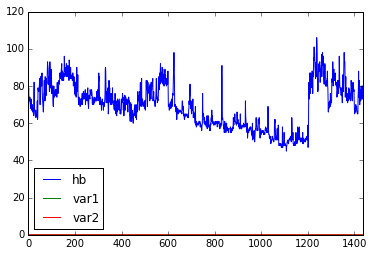

In [18]:
dicDF[dicDF.keys()[194]].plot()

#### Fit of the profile with the multiple-lines approach

In [46]:
counter = 0
dicSolution = {}
for dicKey in dicDF.keys():
    counter += 1; print counter, '/', len(dicDF.keys())
    DFtmp = dicDF[dicKey]
    
    bestChi, outputVar = [], []
    
    for jj in np.arange(10): # Using 10 different night region guesses. 
                             # The random distributions are two Gaussians centred at 11pm 
                             # and 6am, with sigma = 4hrs.
        np.random.seed()
        t0, t1 = nan, nan

        while (not(t0<(t1-5.*60.)) # To force t0 being < t1-5
               or t0<400 or t1>1350): # To force t0 and t1 to be in an acceptable range
            t0 = np.random.normal(loc=660,scale=4.*60.)
            t1 = np.random.normal(loc=1080,scale=4.*60.)

        guessNightTime = [t0, t1]
        # guessNightTime = [660, 1080] # Minutes of sleeping time (11pm-6am)
        # This can be found more efficiently somehow else (e.g. rolling 
        # Gini coefficient, accelerometer std, ...)
        
        # Initial guesses

#         if np.max(DFtmp['var1']) > 0: # accelerometer data available
#             # Applying threshold
#             acc_threshold = 50
#             selection_acc = np.where(acc<=minAcc)
#             xx, yy = np.array(DFtmp.index)[selection_acc], np.array(DFtmp['hb'])[selection_acc]
#         else:
#             xx, yy = np.array(DFtmp.index), np.array(DFtmp['hb'])
        xx, yy, acc = np.array(DFtmp.index), np.array(DFtmp['hb']), np.array(DFtmp['var1'])
            
        try:
            [sel_1, sel_2, sel_3] = retrieveSelection(xx, guessNightTime)

            values_line_1 = np.polyfit(xx[sel_1], yy[sel_1], 1)
            values_line_2 = np.polyfit(xx[sel_2], yy[sel_2], 1)
            values_line_3 = np.polyfit(xx[sel_3], yy[sel_3], 1)


            initialGuesses = ([values_line_1[0], values_line_2[0], values_line_3[0],  #m
                           values_line_1[1], values_line_2[1], values_line_3[1], #q
                       guessNightTime[0], guessNightTime[1]]) #breaks
            numberLines = 3

            # Pearson's Chi^2 minimization with Nelder-Mead algorithm
            solutionTmp = optimize.minimize(measure_chi2_Lines, 
                                        initialGuesses,
                                        args=(xx, yy, numberLines, acc), 
                                        method='Nelder-Mead', 
                                        options={'disp':False, 
                                                 'maxiter':1e5, 'maxfev':1e5})
            if solutionTmp.success:
                bestChi.append(solutionTmp.fun)
                outputVar.append(solutionTmp.x)

        except TypeError:
            print "Failed iteration."
            
    dicSolution[dicKey] = [outputVar[np.argmin(bestChi)], bestChi[np.argmin(bestChi)]]

1 / 208
2 / 208
3 / 208
4 / 208
5 / 208
6 / 208
7 / 208
8 / 208
9 / 208
10 / 208
11 / 208
12 / 208
13 / 208
14 / 208
15 / 208
16 / 208
17 / 208
18 / 208
19 / 208
20 / 208
21 / 208
22 / 208
23 / 208
24 / 208
25 / 208
26 / 208
27 / 208
28 / 208
29 / 208
30 / 208
31 / 208
32 / 208
33 / 208
34 / 208
35 / 208
36 / 208
37 / 208
38 / 208
39 / 208
40 / 208
41 / 208
42 / 208
43 / 208
44 / 208
45 / 208
46 / 208
47 / 208
48 / 208
49 / 208
50 / 208
51 / 208
52 / 208
53 / 208
54 / 208
55 / 208
56 / 208
57 / 208
58 / 208
59 / 208
60 / 208
61 / 208
62 / 208
63 / 208
64 / 208
65 / 208
66 / 208
67 / 208
68 / 208
69 / 208
70 / 208
71 / 208
72 / 208
73 / 208
74 / 208
75 / 208
76 / 208
77 / 208
78 / 208
79 / 208
80 / 208
81 / 208
82 / 208
83 / 208
84 / 208
85 / 208
86 / 208
87 / 208
88 / 208
89 / 208
90 / 208
91 / 208
92 / 208
93 / 208
94 / 208
95 / 208
96 / 208
97 / 208
98 / 208
99 / 208
100 / 208
101 / 208
102 / 208
103 / 208
104 / 208
105 / 208
106 / 208
107 / 208
108 / 208
109 / 208
110 / 208
111 / 20

In [6]:
# Creating plots
if not(os.path.exists('Plots')):
    os.mkdir('Plots')

for ii in dicSolution.keys():
    print ii
    pathOut = 'Plots/'+ii[13:-3]+'pdf'
    DFtmp = dicDF[ii]
    plt.ioff()
    fig = figure(num=0, figsize=(6,5))
    clf()
    
    DFtmp.plot()

    plot(xx[sel_1], xx[sel_1]*values_line_1[0]+values_line_1[1], c='m', label='Guess')
    plot(xx[sel_2], xx[sel_2]*values_line_2[0]+values_line_2[1], c='m')
    plot(xx[sel_3], xx[sel_3]*values_line_3[0]+values_line_3[1], c='m')

    solution = dicSolution[ii][0] # Minimization solution
    
    [sel_1new, sel_2new, sel_3new] = retrieveSelection(xx, [solution[-2], solution[-1]])
    plot(xx[sel_1new], xx[sel_1new]*solution[0]+solution[3], c='k', label='Best fit')
    plot(xx[sel_2new], xx[sel_2new]*solution[1]+solution[4], c='k')
    plot(xx[sel_3new], xx[sel_3new]*solution[2]+solution[5], c='k')
    axvline(x=solution[-2], ymin=-30, ymax = 30, linewidth=2, color='k')
    axvline(x=solution[-1], ymin=-30, ymax = 30, linewidth=2, color='k')
    legend(loc=1, fontsize=8)
    ylabel('HB/min'); xlabel('min'); title(r'$\chi^{2}=$'+str(round(dicSolution[ii][1],2)))
    ylim([0,250])
    savefig(pathOut, bbox_inches='tight')

Fileset0_csv/HL118025.csv
Fileset0_csv/HL159044.csv
Fileset0_csv/HL477022.csv
Fileset0_csv/Hl200003.csv
Fileset0_csv/HL142044.csv
Fileset0_csv/HL484059.csv
Fileset0_csv/HL219079.csv
Fileset0_csv/HL117063.csv
Fileset0_csv/HL148014.csv
Fileset0_csv/HL137050.csv
Fileset0_csv/K218R1.csv
Fileset0_csv/HL135063.csv
Fileset0_csv/HL148037.csv
Fileset0_csv/BKA00050.csv
Fileset0_csv/HL148043.csv
Fileset0_csv/HL066036.csv
Fileset0_csv/AUP00003.csv
Fileset0_csv/HL151058.csv
Fileset0_csv/HL268100.csv
Fileset0_csv/HL135025.csv
Fileset0_csv/AUT00045.csv
Fileset0_csv/HL0403-95.csv
Fileset0_csv/Hl224031.csv
Fileset0_csv/HL135007.csv
Fileset0_csv/am300703.csv
Fileset0_csv/HL244033.csv
Fileset0_csv/HL066045.csv
Fileset0_csv/HL490023.csv
Fileset0_csv/HL062004.csv
Fileset0_csv/HL142045.csv
Fileset0_csv/Hl116054.csv
Fileset0_csv/HL328018.csv
Fileset0_csv/PB220695.csv
Fileset0_csv/HL012128.csv
Fileset0_csv/HL135022.csv
Fileset0_csv/HL135027.csv
Fileset0_csv/HL481010.csv
Fileset0_csv/HL201055.csv
Fileset0_csv/

/Users/nicola/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


### Trying to use accelerometer data

In [116]:
def plotSecondLine(inputArr):
    m, q = inputArr[1], inputArr[4]
    rr = np.arange(inputArr[6],inputArr[7])
    plot(rr, rr*m+q)

plt.ion()

listBadFit = []
ID = []
counter = 0
for ii in dicDF.keys():
    ID.append(ii)
    if max(dicDF[ii].var1) > 0:
        yy = smooth(dicDF[ii].var1, window_len=60)
        # Selecting sleeping region from fit
        rr = np.arange(len(yy))
        selRegion = np.where((rr<dicSolution[ii][0][7]) & (rr>=dicSolution[ii][0][6]))
        acc = np.mean(yy[selRegion])
        if acc > 20:
#             figure()
#             dicDF[ii].plot()
#             axvline(dicSolution[ii][0][6]); axvline(dicSolution[ii][0][7])
#             plotSecondLine(dicSolution[ii][0]) 
#             title(acc)
            listBadFit.append(True)
            counter += 1
        else:
            listBadFit.append(False)
    else:
        listBadFit.append(nan)
    
# ii = dicDF.keys()[20]
# dicDF[ii].plot()


# axvline(dicSolution[ii][0][6]); axvline(dicSolution[ii][0][7])
# # plot(dicDF[ii].var1
# plotSecondLine(dicSolution[ii][0]) 
# plot(yy)

In [119]:
# Saving bad fit in dataframe (and in R readable format)
seriesBadFit = pd.Series(listBadFit)
seriesID = pd.Series(ID)

dic_badfit = {'ID':seriesID, 'BadFit': seriesBadFit}

df_badfit = pd.DataFrame(dic_badfit)
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

## get a reference to the R function 
write_csv = robjects.r('write.csv')
## save 
write_csv(df_badfit,'BadFit.csv')

rpy2.rinterface.NULL

#### DFA

In [ ]:
# Detrended Fluctuation analysis
# check tutorial here: http://localhost:8888/notebooks/mdfaintro.ipynb
# The closer the result to 0.5, the closer to white noise the profile

from pyeeg import *

DFA_tot, DFA_sel, DFA_sel_detrended = [], [], []

# windowSize = [5,10,15,20,25,50,100,200,300]
def getWindowSize(inputArray):
    ll = len(inputArray)
    return np.logspace(np.log2(ll/5.),np.log2(ll-50.),num=20,base=2.)

for ii in np.arange(len(DF)):
    xx_ii = np.arange(len(DF.ix[ii].HB))
    selSleep_ii = np.where((xx_ii>DF.ix[ii].Sleep+60) &
              (xx_ii<=DF.ix[ii].Awake-60))
    HB_ii = DF.ix[ii]['HB']
    HB_ii_sel = HB_ii[selSleep_ii]
    
    DFA_tot.append(dfa(HB_ii, L=getWindowSize(HB_ii)))
    DFA_sel.append(dfa(HB_ii_sel, L=getWindowSize(HB_ii_sel)))#,10,15,20,25,50,100,200,300]))
    
    yy_ii = xx_ii*DF.ix[ii].Slope + DF.ix[ii].intercept
    HB_ii_sel_detrended = (HB_ii/yy_ii)[selSleep_ii]
    
    DFA_sel_detrended.append(dfa(HB_ii_sel_detrended, L=getWindowSize(HB_ii_sel_detrended)))#,10,15,20,25,50,100,200,300]))
    


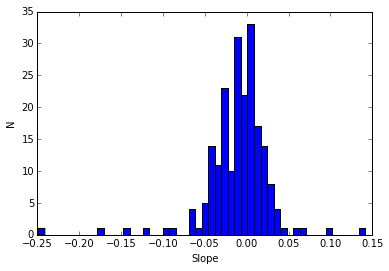

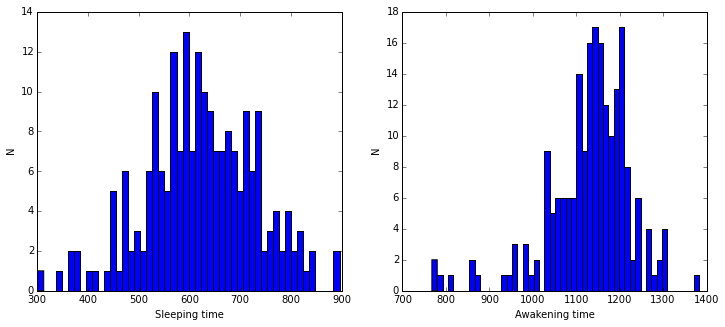

In [11]:
# Creating histograms and preparing dataframe
slope_2 = []
intercept_2 = []
sleepingtime = []
awakingtime = []
chi2 = []
for ii in dicSolution.keys():
    slope_2.append(dicSolution[ii][0][1])
    intercept_2.append(dicSolution[ii][0][4])
    sleepingtime.append(dicSolution[ii][0][6])
    awakingtime.append(dicSolution[ii][0][7])
    chi2.append(dicSolution[ii][1])

# Plot
plt.ion()
figure(0)
clf()
hh = hist(slope_2, 50)
xlabel('Slope'); ylabel('N')

figure(num=1, figsize=(12,5))
ax1, ax2 = subplot(121), subplot(122)
hh_sleep = ax1.hist(sleepingtime, 50); ax1.set_xlabel('Sleeping time'); ax1.set_ylabel('N')
hh_awake = ax2.hist(awakingtime, 50); ax2.set_xlabel('Awakening time'); ax2.set_ylabel('N')



# SAVE Slopes as pandas DF -> csv

seriesSleepTime_fit = pd.Series(sleepingtime)
seriesAwakeTime_fit = pd.Series(awakingtime)
seriesSlope_fit = pd.Series(slope_2)
seriesIntercept_fit = pd.Series(intercept_2)
seriesID = pd.Series(dicSolution.keys())
seriesChi2 = pd.Series(chi2)
#seriesSolution = pd.Series(dicSolution, dtype='object')

dic_fit = {'ID':seriesID, 'Slope': seriesSlope_fit, 'Intercept': seriesIntercept_fit, 
           'SleepTime': seriesSleepTime_fit, 'AwakeTime': seriesAwakeTime_fit, 
           'Chi2':seriesChi2
          }

df_fit = pd.DataFrame(dic_fit)    

In [14]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# Save series of slopes as .csv
write_csv = robjects.r('write.csv')
write_csv(df_fit,'Fit.csv')

# Save everything into pickle data file
outFile = open('fitData.dat', 'wb')
pickle.dump(dic_fit, outFile)
outFile.close()

#### Example of issue with sleeping/awakening time

Optimization terminated successfully.
         Current function value: 635.157296
         Iterations: 2316
         Function evaluations: 3724


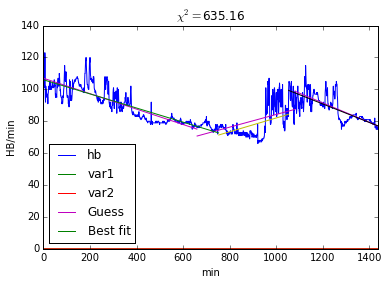

In [286]:
DFtmp = dicDF['Fileset0_csv/KH2.csv']
   
    # Initial guesses
xx, yy, acc = np.array(DFtmp.index), np.array(DFtmp['hb']), np.array(DFtmp['var1'])
guessNightTime = [400, 900] 

guessNightTime = [660, 1080]# Minutes of sleeping time (11pm-6am)
# This can be found more efficiently somehow else (e.g. rolling 
# Gini coefficient, accelerometer std, ...)

[sel_1, sel_2, sel_3] = retrieveSelection(xx, guessNightTime)

values_line_1 = np.polyfit(xx[sel_1], yy[sel_1], 1)
values_line_2 = np.polyfit(xx[sel_2], yy[sel_2], 1)
values_line_3 = np.polyfit(xx[sel_3], yy[sel_3], 1)


initialGuesses = ([values_line_1[0], values_line_2[0], values_line_3[0],  #m
                   values_line_1[1], values_line_2[1], values_line_3[1], #q
                   guessNightTime[0], guessNightTime[1]]) #breaks
numberLines = 3
    
    # Pearson's Chi^2 minimization with Nelder-Mead algorithm

solution = optimize.minimize(measure_chi2_Lines, 
                                initialGuesses,
                                args=(xx,yy, numberLines, acc), 
                                method='Nelder-Mead', 
                                options={'disp':True, 
                                         'maxiter':1e5, 'maxfev':1e5, 
                                        'xtol':1e-9})

plt.ion()
figure(1)
plt.clf()
DFtmp.plot()
plot(xx[sel_1], xx[sel_1]*values_line_1[0]+values_line_1[1], c='m', label='Guess')
plot(xx[sel_2], xx[sel_2]*values_line_2[0]+values_line_2[1], c='m')
plot(xx[sel_3], xx[sel_3]*values_line_3[0]+values_line_3[1], c='m')

[sel_1new, sel_2new, sel_3new] = retrieveSelection(xx, [solution.x[-2], solution.x[-1]])
plot(xx[sel_1new], xx[sel_1new]*solution.x[0]+solution.x[3], c='g', label='Best fit')
plot(xx[sel_2new], xx[sel_2new]*solution.x[1]+solution.x[4], c='y')
plot(xx[sel_3new], xx[sel_3new]*solution.x[2]+solution.x[5], c='k')
legend(loc=3)
ylabel('HB/min'); xlabel('min'); title(r'$\chi^{2}=$'+str(round(solution.fun,2)))
     

#### Measuring the inequality within the sleeping time and look for correlations with the profile's slope

In [288]:
listGini, listSlopes, listStd, listStdDiff, ID = [], [], [], [], []
for ii in dicDF.keys(): 
    ID.append(ii)
    df_tmp = df_fit.loc[df_fit['ID'] == ii]
    t0, t1 = int(round(df_tmp['SleepTime'])), int(round(df_tmp['AwakeTime']))
    sleepProfile = dicDF[ii]['hb'][t0:t1]
    
    mm, qq = dicSolution[ii][0][1], dicSolution[ii][0][4]
    bestfit_line = np.arange(t0,t1)*mm+qq
    normSleepProfile = sleepProfile / bestfit_line
    
    listGini.append(gini(normSleepProfile))
    listSlopes.append(mm)
    listStd.append(std(normSleepProfile))
    
    # Measuring the scatter of the minute-variability array
    listDiff = []
    for jj in np.arange(t0, t1-1):
        listDiff.append(dicDF[ii]['hb'][jj+1]-dicDF[ii]['hb'][jj])
    
    listStdDiff.append(np.std(listDiff)) 

In [163]:
# Creating dataframe with slope and stuff
seriesSlope = pd.Series(listSlopes)
seriesID = pd.Series(ID)
seriesGini = pd.Series(listGini)
seriesStd = pd.Series(listStd)
seriesStdDiff = pd.Series(listStdDiff)

dic_slope = {'ID':seriesID, 'Slope': seriesSlope, 
           'Gini': seriesGini, 'Std': seriesStd, 'StdDiff':seriesStdDiff}

df_slope = pd.DataFrame(dic_slope)  

import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

## get a reference to the R function 
write_csv = robjects.r('write.csv')
## save 
write_csv(df_slope,'fit.csv')

rpy2.rinterface.NULL

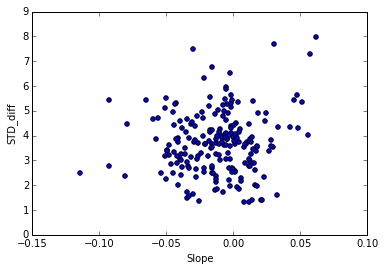

In [155]:
scatter(listSlopes, listStdDiff)
xlabel('Slope'); ylabel('STD_diff')

### TESTING

1.68127699937


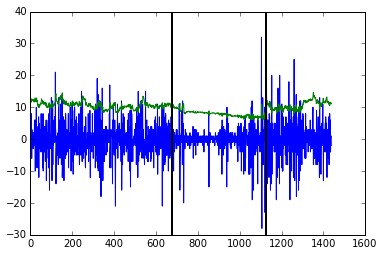

In [149]:
# Checking the differences between different minute's 
# measurements as an estimation for the sleeping time
ii = dicDF.keys()[99]
listDiff = []
for jj in np.arange(len(dicDF[ii]['hb'])-1):
        listDiff.append(dicDF[ii]['hb'][jj+1]-dicDF[ii]['hb'][jj])
        
plot(listDiff)
plot(dicDF[ii]['hb']*10/np.median(dicDF[ii]['hb']))
sleep = float(df_fit.loc[df_fit['ID'] == ii]['SleepTime'])
awake = float(df_fit.loc[df_fit['ID'] == ii]['AwakeTime'])
axvline(x=sleep, ymin=-30, ymax = 30, linewidth=2, color='k')
axvline(x=awake, ymin=-30, ymax = 30, linewidth=2, color='k')
print std(dicDF[ii]['hb']*10/np.median(dicDF[ii]['hb']))

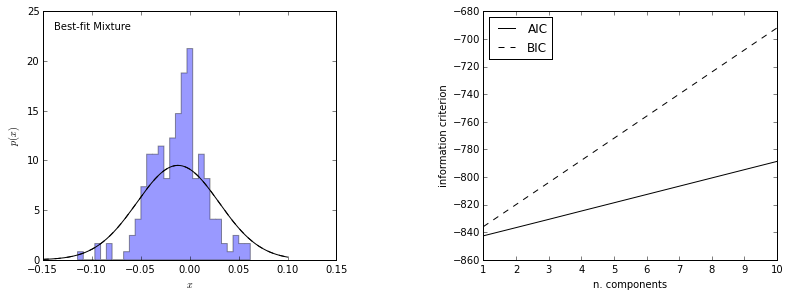

In [213]:
# Fitting slope histogram with Gaussian mixture model
from sklearn import mixture
from sklearn.mixture import GMM
np.random.seed(1)

X = np.array(slope_2)
X = X.reshape(-1, 1)

# fit models with 1-10 components
N = np.arange(1,11)
models = [None for ii in range(len(N))]

for ii in range(len(N)):
    models[ii] = mixture.GMM(n_components=N[ii]).fit(X)
    
# compute the AIC and the BIC
AIC = [mm.aic(X) for mm in models]
BIC = [mm.bic(X) for mm in models]

#------------------------------------------------------------
# Plot the results
#  We'll use three panels:
#   1) data + best-fit mixture
#   2) AIC and BIC vs number of components
#   3) probability that a point came from each component
plt.ion()
fig = plt.figure(figsize=(12, 5))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)

# # plot 1: data + best-fit mixture
ax = fig.add_subplot(121)
M_best = models[np.argmin(AIC)]

x = np.transpose(np.linspace(-0.15, 0.1, len(X)))
x = x.reshape(-1, 1)


logprob, responsibilities = M_best.score_samples(x)

pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]


ax.hist(X, 30, normed=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')


# plot 2: AIC and BIC
ax = fig.add_subplot(122)
ax.plot(N, AIC, '-k', label='AIC')
ax.plot(N, BIC, '--k', label='BIC')
ax.set_xlabel('n. components')
ax.set_ylabel('information criterion')
ax.legend(loc=2)


# NOT ABLE TO FIT WITH MULTIPLE GAUSSIANS

In [ ]:
# Fit with multiple lines and extract chi^2 with brute-force algorithm
# Pearson's Chi^2 minimization with Nelder-Mead algorithm

ranges = [slice(-0.5,0.5, 0.1), slice(-0.5,0.5, 0.1), slice(-0.5,0.5, 0.1),
          slice(40,100, 5), slice(40,100, 5), slice(40,100, 5),
          slice(600,720,5), slice(1000,1260,5) 
         ]

solution = optimize.brute(measure_chi2_Lines, 
                          ranges,
                          args=(xx, yy, numberLines),
                          Ns=200 #Number points
                        #,disp=True
                        #,full_output=True
                         )
                           
# DFtmp.plot()

# plot(xx[sel_1], xx[sel_1]*values_line_1[0]+values_line_1[1], c='r')
# plot(xx[sel_2], xx[sel_2]*values_line_2[0]+values_line_2[1], c='r')
# plot(xx[sel_3], xx[sel_3]*values_line_3[0]+values_line_3[1], c='r')


# # SOLUTION
# print solution

# [sel_1new, sel_2new, sel_3new] = retrieveSelection(xx, [solution.x[-2], solution.x[-1]])
# plot(xx[sel_1new], xx[sel_1new]*solution.x[0]+solution.x[3], c='k')
# plot(xx[sel_2new], xx[sel_2new]*solution.x[1]+solution.x[4], c='k')
# plot(xx[sel_3new], xx[sel_3new]*solution.x[2]+solution.x[5], c='k')

In [124]:
solution

  status: 1
    nfev: 100000
 success: False
     fun: 426970.3873590742
       x: array([  0.00000000e+00,  -2.00000000e-01,   0.00000000e+00,
         1.20000000e+02,   1.89000000e+02,   1.20000000e+02,
         5.00000000e+02,   1.20000000e+03])
 message: 'Maximum number of function evaluations has been exceeded.'
     nit: 35609

In [ ]:
# Smooth data and try to fit it again